In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix


C:\Users\46rin\AppData\Roaming\Python\Python313\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Users\46rin\AppData\Roaming\Python\Python313\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Users\46rin\AppData\Roaming\Python\Python313\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/resource_handle.proto. Please 

In [2]:
IMG_SIZE = 256
BATCH_SIZE = 16
dataset = r'C:\Users\46rin\Documents\cleaned_dataset'

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.7, 1.3],
    channel_shift_range=25.0,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 80% train / 20% validation
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen = train_datagen.flow_from_directory(
    dataset,               # dataset folder should contain /cats and /dogs
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="training"
)

val_gen = val_datagen.flow_from_directory(
    dataset,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="validation",
    shuffle=False
)


Found 1460 images belonging to 2 classes.
Found 364 images belonging to 2 classes.


In [4]:
print(train_gen.class_indices)
print(val_gen.class_indices)

{'attentive': 0, 'distracted': 1}
{'attentive': 0, 'distracted': 1}


In [5]:
base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.trainable = False  # Freeze base model initially

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.4),
    layers.Dense(1, activation="sigmoid")  # Binary output
])

# -----------------------------------------------------
# 4. Compile Model
# -----------------------------------------------------
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)


C:\Users\46rin\AppData\Local\Temp\ipykernel_22364\2288533707.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


In [6]:
# Stop training if val_loss doesn’t improve for 5 epochs
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

# Save the best model (based on val_loss)
checkpoint = ModelCheckpoint(
    "best_model.h5",
    monitor="val_loss",
    save_best_only=True,
    mode="min"
)

# Reduce learning rate when val_loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,       # reduce LR by half
    patience=3,       # wait 3 epochs before reducing
    min_lr=1e-7       # don’t go below this LR
)

callbacks_list = [early_stop, checkpoint, reduce_lr]


In [7]:
history_1 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=callbacks_list
)

C:\Users\46rin\AppData\Roaming\Python\Python313\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.4880 - loss: 0.7964 

92/92 ━━━━━━━━━━━━━━━━━━━━ 42s 422ms/step - accuracy: 0.4986 - loss: 0.7861 - val_accuracy: 0.6319 - val_loss: 0.6506 - learning_rate: 1.0000e-04
Epoch 2/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.5691 - loss: 0.7104 

92/92 ━━━━━━━━━━━━━━━━━━━━ 38s 415ms/step - accuracy: 0.5781 - loss: 0.6910 - val_accuracy: 0.7390 - val_loss: 0.5973 - learning_rate: 1.0000e-04
Epoch 3/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.6237 - loss: 0.6434 

92/92 ━━━━━━━━━━━━━━━━━━━━ 38s 415ms/step - accuracy: 0.6322 - loss: 0.6265 - val_accuracy: 0.7500 - val_loss: 0.5631 - learning_rate: 1.0000e-04
Epoch 4/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.6518 - loss: 0.5988 

92/92 ━━━━━━━━━━━━━━━━━━━━ 38s 416ms/step - accuracy: 0.6973 - loss: 0.5649 - val_accuracy: 0.8022 - val_loss: 0.5340 - learning_rate: 1.0000e-04
Epoch 5/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.7255 - loss: 0.5324 

92/92 ━━━━━━━━━━━━━━━━━━━━ 38s 413ms/step - accuracy: 0.7342 - loss: 0.5298 - val_accuracy: 0.8352 - val_loss: 0.5115 - learning_rate: 1.0000e-04
Epoch 6/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.7215 - loss: 0.5369 

92/92 ━━━━━━━━━━━━━━━━━━━━ 38s 414ms/step - accuracy: 0.7370 - loss: 0.5168 - val_accuracy: 0.8214 - val_loss: 0.4935 - learning_rate: 1.0000e-04
Epoch 7/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.7600 - loss: 0.4725 

92/92 ━━━━━━━━━━━━━━━━━━━━ 38s 418ms/step - accuracy: 0.7610 - loss: 0.4696 - val_accuracy: 0.8352 - val_loss: 0.4788 - learning_rate: 1.0000e-04
Epoch 8/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.7897 - loss: 0.4620 

92/92 ━━━━━━━━━━━━━━━━━━━━ 39s 418ms/step - accuracy: 0.7897 - loss: 0.4549 - val_accuracy: 0.8324 - val_loss: 0.4682 - learning_rate: 1.0000e-04
Epoch 9/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.8007 - loss: 0.4332 

92/92 ━━━━━━━━━━━━━━━━━━━━ 38s 415ms/step - accuracy: 0.7966 - loss: 0.4382 - val_accuracy: 0.8159 - val_loss: 0.4590 - learning_rate: 1.0000e-04
Epoch 10/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.7962 - loss: 0.4399 

92/92 ━━━━━━━━━━━━━━━━━━━━ 39s 418ms/step - accuracy: 0.8158 - loss: 0.4257 - val_accuracy: 0.8379 - val_loss: 0.4500 - learning_rate: 1.0000e-04
Epoch 11/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.8158 - loss: 0.4039 

92/92 ━━━━━━━━━━━━━━━━━━━━ 39s 418ms/step - accuracy: 0.8178 - loss: 0.4050 - val_accuracy: 0.8297 - val_loss: 0.4427 - learning_rate: 1.0000e-04
Epoch 12/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.8426 - loss: 0.3887 

92/92 ━━━━━━━━━━━━━━━━━━━━ 39s 420ms/step - accuracy: 0.8370 - loss: 0.3882 - val_accuracy: 0.8352 - val_loss: 0.4365 - learning_rate: 1.0000e-04
Epoch 13/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.8373 - loss: 0.3956 

92/92 ━━━━━━━━━━━━━━━━━━━━ 39s 423ms/step - accuracy: 0.8281 - loss: 0.3919 - val_accuracy: 0.8324 - val_loss: 0.4278 - learning_rate: 1.0000e-04
Epoch 14/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.8437 - loss: 0.3709 

92/92 ━━━━━━━━━━━━━━━━━━━━ 40s 430ms/step - accuracy: 0.8336 - loss: 0.3885 - val_accuracy: 0.8352 - val_loss: 0.4238 - learning_rate: 1.0000e-04
Epoch 15/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.8587 - loss: 0.3513 

92/92 ━━━━━━━━━━━━━━━━━━━━ 40s 439ms/step - accuracy: 0.8486 - loss: 0.3571 - val_accuracy: 0.8434 - val_loss: 0.4180 - learning_rate: 1.0000e-04
Epoch 16/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.8440 - loss: 0.3777 

92/92 ━━━━━━━━━━━━━━━━━━━━ 39s 425ms/step - accuracy: 0.8452 - loss: 0.3692 - val_accuracy: 0.8462 - val_loss: 0.4171 - learning_rate: 1.0000e-04
Epoch 17/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.8314 - loss: 0.3911 

92/92 ━━━━━━━━━━━━━━━━━━━━ 39s 426ms/step - accuracy: 0.8486 - loss: 0.3697 - val_accuracy: 0.8489 - val_loss: 0.4112 - learning_rate: 1.0000e-04
Epoch 18/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.8678 - loss: 0.3391 

92/92 ━━━━━━━━━━━━━━━━━━━━ 39s 420ms/step - accuracy: 0.8445 - loss: 0.3653 - val_accuracy: 0.8516 - val_loss: 0.4069 - learning_rate: 1.0000e-04
Epoch 19/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.8602 - loss: 0.3368 

92/92 ━━━━━━━━━━━━━━━━━━━━ 39s 425ms/step - accuracy: 0.8527 - loss: 0.3497 - val_accuracy: 0.8544 - val_loss: 0.4005 - learning_rate: 1.0000e-04
Epoch 20/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.8573 - loss: 0.3341 

92/92 ━━━━━━━━━━━━━━━━━━━━ 39s 425ms/step - accuracy: 0.8582 - loss: 0.3318 - val_accuracy: 0.8599 - val_loss: 0.3980 - learning_rate: 1.0000e-04
Epoch 21/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.8466 - loss: 0.3498 

92/92 ━━━━━━━━━━━━━━━━━━━━ 40s 435ms/step - accuracy: 0.8548 - loss: 0.3451 - val_accuracy: 0.8516 - val_loss: 0.3926 - learning_rate: 1.0000e-04
Epoch 22/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.8499 - loss: 0.3441 

92/92 ━━━━━━━━━━━━━━━━━━━━ 39s 424ms/step - accuracy: 0.8521 - loss: 0.3459 - val_accuracy: 0.8599 - val_loss: 0.3916 - learning_rate: 1.0000e-04
Epoch 23/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.8301 - loss: 0.3567 

92/92 ━━━━━━━━━━━━━━━━━━━━ 41s 447ms/step - accuracy: 0.8486 - loss: 0.3331 - val_accuracy: 0.8599 - val_loss: 0.3895 - learning_rate: 1.0000e-04
Epoch 24/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.8687 - loss: 0.3160 

92/92 ━━━━━━━━━━━━━━━━━━━━ 41s 442ms/step - accuracy: 0.8610 - loss: 0.3187 - val_accuracy: 0.8626 - val_loss: 0.3868 - learning_rate: 1.0000e-04
Epoch 25/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.8529 - loss: 0.3452 

92/92 ━━━━━━━━━━━━━━━━━━━━ 40s 439ms/step - accuracy: 0.8610 - loss: 0.3290 - val_accuracy: 0.8709 - val_loss: 0.3863 - learning_rate: 1.0000e-04
Epoch 26/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.8608 - loss: 0.3175 

92/92 ━━━━━━━━━━━━━━━━━━━━ 39s 426ms/step - accuracy: 0.8637 - loss: 0.3173 - val_accuracy: 0.8599 - val_loss: 0.3835 - learning_rate: 1.0000e-04
Epoch 27/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.8732 - loss: 0.2976 

92/92 ━━━━━━━━━━━━━━━━━━━━ 39s 428ms/step - accuracy: 0.8747 - loss: 0.3067 - val_accuracy: 0.8626 - val_loss: 0.3803 - learning_rate: 1.0000e-04
Epoch 28/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8736 - loss: 0.3004 

92/92 ━━━━━━━━━━━━━━━━━━━━ 39s 420ms/step - accuracy: 0.8692 - loss: 0.3134 - val_accuracy: 0.8709 - val_loss: 0.3789 - learning_rate: 1.0000e-04
Epoch 29/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.8705 - loss: 0.3076 

92/92 ━━━━━━━━━━━━━━━━━━━━ 39s 424ms/step - accuracy: 0.8637 - loss: 0.3171 - val_accuracy: 0.8709 - val_loss: 0.3770 - learning_rate: 1.0000e-04
Epoch 30/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.8754 - loss: 0.2979 

92/92 ━━━━━━━━━━━━━━━━━━━━ 39s 423ms/step - accuracy: 0.8753 - loss: 0.3052 - val_accuracy: 0.8681 - val_loss: 0.3757 - learning_rate: 1.0000e-04


In [ ]:
# Unfreeze the top layers of base_model
base_model.trainable = True

# Optional: only unfreeze last N layers (e.g., last 50)
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Recompile with a LOWER learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),  # smaller LR
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history_2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[early_stop, checkpoint, reduce_lr]
)

In [18]:
from tensorflow.keras.models import load_model
best_model = load_model("best_model.h5")
# -----------------------------------------------------
# 1. Predictions on validation set
# -----------------------------------------------------
val_gen.reset()
y_true = val_gen.classes
y_pred_probs = best_model.predict(val_gen)
y_pred = (y_pred_probs > 0.5).astype("int32").ravel()

for i in range(10):
    print(f"True: {y_true[i]}, Pred: {y_pred[i]}, Prob: {y_pred_probs[i][0]:.3f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 232ms/step 
True: 0, Pred: 1, Prob: 0.667
True: 0, Pred: 1, Prob: 0.763
True: 0, Pred: 0, Prob: 0.278
True: 0, Pred: 0, Prob: 0.343
True: 0, Pred: 0, Prob: 0.376
True: 0, Pred: 0, Prob: 0.256
True: 0, Pred: 0, Prob: 0.429
True: 0, Pred: 0, Prob: 0.351
True: 0, Pred: 0, Prob: 0.316
True: 0, Pred: 0, Prob: 0.280


In [19]:
target_names = list(val_gen.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=target_names))


              precision    recall  f1-score   support

   attentive       0.84      0.91      0.87       183
  distracted       0.90      0.82      0.86       181

    accuracy                           0.87       364
   macro avg       0.87      0.87      0.87       364
weighted avg       0.87      0.87      0.87       364



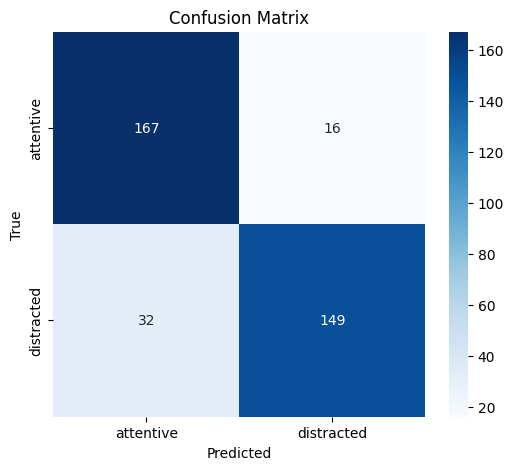

In [10]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

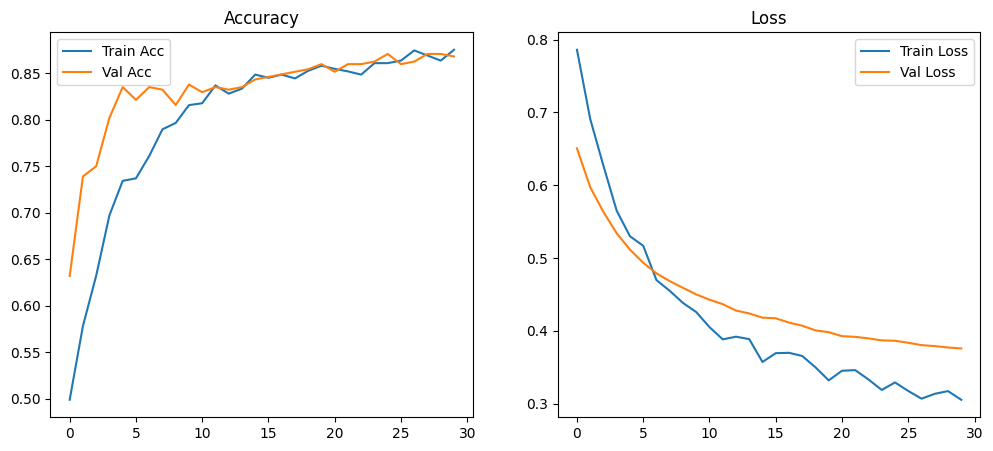

NameError: name 'history_2' is not defined

In [11]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12,5))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(epochs_range, acc, label="Train Acc")
    plt.plot(epochs_range, val_acc, label="Val Acc")
    plt.legend()
    plt.title("Accuracy")

    # Loss
    plt.subplot(1,2,2)
    plt.plot(epochs_range, loss, label="Train Loss")
    plt.plot(epochs_range, val_loss, label="Val Loss")
    plt.legend()
    plt.title("Loss")

    plt.show()

plot_history(history_1) # Before fine-tuning
plot_history(history_2)

In [ ]:
best_model.save("mobilenetv288_newfinetune.h5")
